In [7]:
#Imports
import os
from random import uniform
import subprocess
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
from functools import partial
import time
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score

In [72]:
test_data = pd.read_excel('../experimental-data/sucrose-OD-IPTG-sweep.xls',sheet_name='data')
from scipy.optimize import curve_fit
def od_func(x):
    """Exponential fit to IPTG vs OD750 experimental data

    Args:
        x (float): IPTG concentration (mM)

    Returns:
        float: Smoothed OD750
    """
    return 0.25482 * np.exp(-x/.06811) + 1.12893
def suc_func(x,a,b,c):
    return a*np.exp(-x/b)+c
# Smooth OD750 data for fitting
test_data.loc[:,'OD750'] = od_func(test_data.IPTG)
#popt, pcov = curve_fit(suc_func, test_data.IPTG, test_data.Sucrose)
    #Compare output with experimental data
#OD = interpolate.interp1d(test_data.IPTG,test_data.OD750)
#Sucrose = interpolate.interp1d(test_data.IPTG,test_data.Sucrose)
#sim = interpolate.interp1d(df.Hours.to_numpy(),df.OD600.to_numpy())
#x_range = np.arange(0,1,.01)
#plt.plot(x_range,suc_func(x_range))
#plt.plot(test_data.IPTG,test_data.Sucrose,marker='o')
#plt.plot(x_range, suc_func(x_range, *popt), 'r-')
#xr = np.array([0.001,.01,.05,0.2,1])
#plt.plot(xr,suc_func(xr, *popt),marker='s',ls='')
#plt.plot(x_range,od_func(x_range))
#residual = abs(r2_score(exp(x_range),sim(x_range))-1)

In [70]:
t2 = test_data.copy()
t2.loc[2,'OD750']=1.40
t2.loc[4,'OD750']=1.23
t2.sort_values(by='IPTG',inplace=True)
print(t2)
abs(r2_score(t2[['OD750','Sucrose']],test_data[['OD750','Sucrose']])-1)

    IPTG     OD750   Sucrose
0  0.000  1.370000  0.036666
1  0.005  1.360000  0.068554
2  0.010  1.400000  0.199934
3  0.020  1.283333  0.504447
4  0.050  1.230000  0.823351
5  0.100  1.210000  0.955296
6  0.200  1.166667  1.107202
7  0.500  1.106667  1.146224
8  1.000  1.128333  1.105824


0.0012505885122411353

In [2]:
# Base install of NUFEB
os.chdir('/tmp')
os.system('git clone https://github.com/Jsakkos/NUFEB --recursive')
os.chdir('NUFEB')
os.system('git checkout cyano')
initial_compile = subprocess.run('/home/12x/init-compile.sh')


In [3]:
#nufeb_compile = subprocess.run('/home/12x/rapid-compile.sh')


In [4]:
def recompile(alpha,beta,delta,kappa,kappa_2):
    os.chdir('/tmp/NUFEB')
    filein = open( f'/home/12x/nufeb-cyano-e-coli/templates/fix_bio_kinetics_monod2.txt' )
    #read it
    src = Template( filein.read() )
    #do the substitution
    result = src.safe_substitute({'alpha' : alpha, 'beta' : beta, 'delta' : delta,'kappa':kappa,'kappa_2':kappa_2
                                        
                                        })
    with open("/tmp/NUFEB/src/USER-NUFEB/fix_bio_kinetics_monod.cpp","w") as f:
       f.writelines(result)
    #Compile NUFEB
    nufeb_compile = subprocess.run('/home/12x/rapid-compile.sh')

In [5]:
def test_run():
    os.chdir('/tmp/NUFEB')
    os.system('nufeb-clean')
    text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700'
    os.system(text)
    run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)

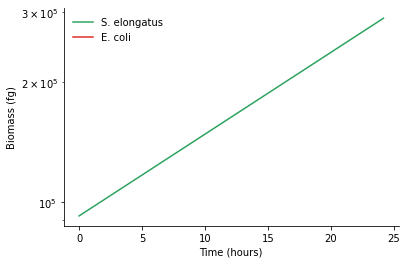

In [6]:
# Test to make sure everything is working
recompile(0.2,8,.01,1e-6)
test_run()
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
data = [utils.get_data(directory=str(x)) for x in folders]
f, ax = plt.subplots()
plot.overall_growth(data[0].biomass,ax=ax)
plt.show()

In [7]:
from tqdm.notebook import tqdm

class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

In [8]:
def func(x):

    alpha = x[0]
    beta = x[1]
    delta = x[2]
    kappa = x[3]
    kappa_2 = x[4]
    mu = x[5]
    rho = x[6]




    #Change input params
    
    os.chdir('/tmp/NUFEB')
    recompile(alpha,beta,delta,kappa,kappa_2)

    #Clean old simulations
    os.system('nufeb-clean')
    #Run simulation
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {mu} --sucR {iptg} --rhocya {rho}'
        os.system(text)

    run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    data = [utils.get_data(directory=str(x)) for x in folders]
    Volume = 1e-4*1e-4*1e-4 #m^3
    CellNum2OD = Volume*1e6/0.3e-8
    SucroseMW = 342.3
    dfs = []
    for x in data:
        temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
        temp.columns=['OD750','Hours','Sucrose']
        temp['IPTG'] = x.metadata['SucRatio']
        dfs.append(temp)
    df = pd.concat(dfs)
    df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
    df.sort_values(by='IPTG',inplace=True)

    #Compare output with experimental data

    return abs(r2_score(df[['OD750','Sucrose']],test_data[['OD750','Sucrose']])-1)
    #Optimize
""" def optimize():
    

    res = gp_minimize(func,                  # the function to minimize
                    ,      # the bounds on each dimension of x
                    acq_func="EI",      # the acquisition function
                    n_calls=5,         # the number of evaluations of f
                    n_random_starts=5,  # the number of random initialization points
                    random_state=1234)
    print(res)
    file_pi = open('results.obj', 'w') 
    pickle.dump(res, file_pi) """

' def optimize():\n    \n\n    res = gp_minimize(func,                  # the function to minimize\n                    ,      # the bounds on each dimension of x\n                    acq_func="EI",      # the acquisition function\n                    n_calls=5,         # the number of evaluations of f\n                    n_random_starts=5,  # the number of random initialization points\n                    random_state=1234)\n    print(res)\n    file_pi = open(\'results.obj\', \'w\') \n    pickle.dump(res, file_pi) '

In [9]:
mu_min = float('1e-6')
mu_max = float('5e-5')
a_min = float('0.01')
a_max = float('0.5')
b_min = float('0')
b_max = float('10')
d_min = float('0')
d_max = float('1e-1')
rho_min = 320
rho_max = 390
kappa_min = float('.01')
kappa_max = float('.05')
kappa2_min = float('.01')
kappa2_max = float('.05')
m_min = float('1e-8')
m_max = float('1e-7')
bounds = [(a_min,a_max),(b_min,b_max),(d_min,d_max),(kappa_min,kappa_max),(kappa2_min,kappa2_max),(m_min,m_max),(mu_min,mu_max),(rho_min,rho_max)]




bounds = [(0.05, .5),(1,10),(0.01,.1),(.000001,.001),(0.000001,0.0001),(320,390)]
n_calls = 100
#et_res = forest_minimize(func, bounds, n_calls=n_calls,callback=[tqdm_skopt(total=n_calls, desc="Random forest")],base_estimator="ET",n_initial_points =20)
gp_res = gp_minimize(func, bounds, n_calls=n_calls,random_state=5348,verbose=True,callback=[tqdm_skopt(total=n_calls, desc="Bayesian opt")])

1256.6027589269893
233.35502345645773
4.104899632936242
3.261946746756424
7.900041623419414
151.24662575139357
4.072121720847331
174.8174106494671
14.453221589432694
281.77566987592485
32.474568323291024
3.5796838627703558
3.1751909839972567
1341.749062020317
191.2528003290495
805.3663824246652
9.038430475566594
1666.485835188184
57.203714316323854
54.768449102546406
4.269702391942974
3.4599151684307383
9.660934643168874
4.155400777621508
20.626200117936193
1.737175527472771
6.331036494454818
76.81856523015972
23.27749885090624
41.34543830611673
56.34434489973012
18.80807171688503
90.50013347829028
28.982416580628765
185.04902522603408
2.863027837117217
323.51186613656614
3.3970585583176276
16.587004033108844
1.2854198773864727
52.02724848231563
319.7402121725454
3.892093295480923
4.218929239950673
6.218206820570134
20.565361605643425
56.11784606492452
23.938410852421313
51.418342531191406
21.616220052681893
42.066502313588316
138.00335637492128
155.40711804148083
103.37945166396844
4.

In [ ]:
plot_convergence(gp_res,yscale='log')

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

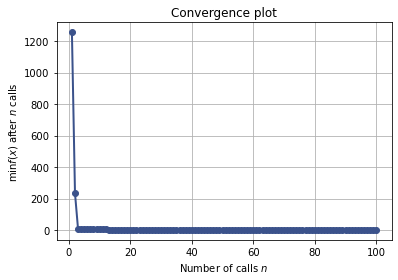

In [10]:
plot_objective(gp_res)

In [12]:
gp_res.x

In [13]:
os.chdir('/tmp/NUFEB')
recompile(gp_res.x[0],gp_res.x[1],gp_res.x[2],gp_res.x[3],gp_res.x[4])

#Clean old simulations
os.system('nufeb-clean')
#Run simulation
for iptg in test_data.IPTG:
    text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {gp_res.x[5]} --sucR {iptg} --rhocya {gp_res.x[6]}'
    os.system(text)

run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

#Extract output

data = [utils.get_data(directory=str(x)) for x in folders]
Volume = 1e-4*1e-4*1e-4 #m^3
CellNum2OD = Volume*1e6/0.3e-8
SucroseMW = 342.3
dfs = []
for x in data:
    temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD750','Hours','Sucrose']
    temp['IPTG'] = x.metadata['SucRatio']
    dfs.append(temp)
df = pd.concat(dfs)
df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
df.sort_values(by='IPTG',inplace=True)


In [ ]:
f, ax = plt.subplots(ncols=2)
ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o')
ax[0].plot(df.IPTG,df.Sucrose)
ax[1].plot(test_data.IPTG,test_data.OD750,marker='o')
ax[1].plot(df.IPTG,df.OD750)